In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from optuna.samplers import TPESampler

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
# Load Data
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')
submission = pd.read_csv('../data/raw/sample_submission.csv')

# Pisahkan Target
X = train.drop(['id', 'diagnosed_diabetes'], axis=1)
y = train['diagnosed_diabetes']
X_test = test.drop(['id'], axis=1)

print(f"Train Shape: {X.shape}, Test Shape: {X_test.shape}")

Train Shape: (700000, 24), Test Shape: (300000, 24)


In [3]:
def create_new_features(df):
    df = df.copy()

    # Pulse Pressure: Selisih sistolik dan diastolik (indikator kesehatan jantung)
    df['pulse_pressure'] = df['systolic_bp'] - df['diastolic_bp']
    # MAP (Mean Arterial Pressure): Rata-rata tekanan darah dalam satu siklus
    df['map'] = (df['systolic_bp'] + (2 * df['diastolic_bp'])) / 3
    
    df['cholesterol_ratio'] = df['ldl_cholesterol'] / (df['hdl_cholesterol'] + 1)
    
    # Kombinasi aktivitas fisik dan diet
    df['lifestyle_score'] = df['physical_activity_minutes_per_week'] * df['diet_score']
    
    # Risiko obesitas meningkat seiring umur
    df['bmi_age_interaction'] = df['bmi'] * df['age']
    
    return df

X = create_new_features(X)
X_test = create_new_features(X_test)

print("New Features Added:")
print(X[['pulse_pressure', 'map', 'cholesterol_ratio']].head())

New Features Added:
   pulse_pressure        map  cholesterol_ratio
0              42  84.000000           1.932203
1              43  91.333333           2.372549
2               6  91.000000           1.900000
3              52  86.333333           1.545455
4              48  76.000000           2.620000


In [4]:
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print(f"Categorical Cols: {len(cat_cols)}")
print(f"Numerical Cols: {len(num_cols)}")

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

scaler = RobustScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Preprocessing Complete.")

Categorical Cols: 6
Numerical Cols: 23
Preprocessing Complete.


In [5]:
def tune_model(model_name, n_trials=10):
    print(f"\n=== Tuning {model_name} ({n_trials} trials) ===")
    
    def objective(trial):
        # --- DEFINISI SEARCH SPACE ---
        if model_name == 'xgboost':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 500, 2500),
                'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
                'n_jobs': -1, 'random_state': 42, 'eval_metric': 'auc'
            }
            model = xgb.XGBClassifier(**params, early_stopping_rounds=50)
            
        elif model_name == 'hgb':
            params = {
                'max_iter': trial.suggest_int('max_iter', 200, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
                'max_depth': trial.suggest_int('max_depth', 5, 20),
                'l2_regularization': trial.suggest_float('l2_regularization', 1e-3, 10.0, log=True),
                'early_stopping': True, 'random_state': 42
            }
            model = HistGradientBoostingClassifier(**params)
            
        elif model_name == 'rf':
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 200, 600),
                'max_depth': trial.suggest_int('max_depth', 5, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                'n_jobs': -1, 'random_state': 42
            }
            model = RandomForestClassifier(**params)

        # --- VALIDASI (3-Fold agar cepat) ---
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = []
        
        # Kita ambil sampel 50% data saja untuk tuning (biar cepat), 
        # tapi nanti training final pakai 100% data.
        # Jika komputermu kuat, hapus bagian sampling ini.
        sample_idx = np.random.choice(len(X), size=int(len(X)*0.5), replace=False)
        X_sample = X.iloc[sample_idx]
        y_sample = y.iloc[sample_idx]
        
        for train_idx, val_idx in kf.split(X_sample, y_sample):
            X_tr, X_val = X_sample.iloc[train_idx], X_sample.iloc[val_idx]
            y_tr, y_val = y_sample.iloc[train_idx], y_sample.iloc[val_idx]
            
            if model_name == 'xgboost':
                model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            else:
                model.fit(X_tr, y_tr)
                
            preds = model.predict_proba(X_val)[:, 1]
            scores.append(roc_auc_score(y_val, preds))
            
        return np.mean(scores)

    study = optuna.create_study(direction='maximize', sampler=TPESampler())
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

best_params_xgb = tune_model('xgboost', n_trials=10)
best_params_hgb = tune_model('hgb', n_trials=10)
best_params_rf  = tune_model('rf', n_trials=10)

best_params_xgb.update({'n_jobs': -1, 'random_state': 42, 'eval_metric': 'auc'})
best_params_hgb.update({'random_state': 42, 'early_stopping': True})
best_params_rf.update({'n_jobs': -1, 'random_state': 42})

with open('../src/config.py', 'a') as f:
    f.write("\n")
    f.write(f"PARAMS_XGB = {best_params_xgb}\n")
    f.write(f"PARAMS_HGB = {best_params_hgb}\n")
    f.write(f"PARAMS_RF = {best_params_rf}\n")

print("\n--- OPTUNA SELESAI ---")
print("Best XGB:", best_params_xgb)
print("Best HGB:", best_params_hgb)
print("Best RF:", best_params_rf)

[I 2026-01-06 09:01:11,475] A new study created in memory with name: no-name-3c562a0d-ba48-4bfe-b2b0-c4e5e8b3978f



=== Tuning xgboost (10 trials) ===


[I 2026-01-06 09:01:20,047] Trial 0 finished with value: 0.7175724924584538 and parameters: {'n_estimators': 1624, 'learning_rate': 0.08364973072699976, 'max_depth': 9, 'subsample': 0.9283620022496905, 'colsample_bytree': 0.78905520832773, 'min_child_weight': 2, 'reg_alpha': 2.200549089127406, 'reg_lambda': 0.10443864803299856}. Best is trial 0 with value: 0.7175724924584538.
[I 2026-01-06 09:02:02,467] Trial 1 finished with value: 0.7207368845744856 and parameters: {'n_estimators': 2241, 'learning_rate': 0.013184071502015103, 'max_depth': 10, 'subsample': 0.6697943406057433, 'colsample_bytree': 0.6368680547580302, 'min_child_weight': 4, 'reg_alpha': 0.32077207663063045, 'reg_lambda': 0.14281058312319886}. Best is trial 1 with value: 0.7207368845744856.
[I 2026-01-06 09:02:25,022] Trial 2 finished with value: 0.7219834723494705 and parameters: {'n_estimators': 603, 'learning_rate': 0.03766801806906329, 'max_depth': 6, 'subsample': 0.8727511356915054, 'colsample_bytree': 0.6316713828749


=== Tuning hgb (10 trials) ===


[I 2026-01-06 09:08:30,549] Trial 0 finished with value: 0.7182851327428547 and parameters: {'max_iter': 778, 'learning_rate': 0.0309780227765858, 'max_depth': 5, 'l2_regularization': 0.04751008405113327}. Best is trial 0 with value: 0.7182851327428547.
[I 2026-01-06 09:08:39,898] Trial 1 finished with value: 0.7196054105060913 and parameters: {'max_iter': 991, 'learning_rate': 0.05900747732032968, 'max_depth': 10, 'l2_regularization': 0.04723004193073991}. Best is trial 1 with value: 0.7196054105060913.
[I 2026-01-06 09:08:48,615] Trial 2 finished with value: 0.7180594520657718 and parameters: {'max_iter': 449, 'learning_rate': 0.05423169333519915, 'max_depth': 20, 'l2_regularization': 0.0013980303217150482}. Best is trial 1 with value: 0.7196054105060913.
[I 2026-01-06 09:08:59,145] Trial 3 finished with value: 0.7087141047487296 and parameters: {'max_iter': 257, 'learning_rate': 0.016672373292891392, 'max_depth': 6, 'l2_regularization': 8.87119646036809}. Best is trial 1 with value:


=== Tuning rf (10 trials) ===


[I 2026-01-06 09:11:47,803] Trial 0 finished with value: 0.6999165739686203 and parameters: {'n_estimators': 391, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.6999165739686203.
[I 2026-01-06 09:12:16,194] Trial 1 finished with value: 0.6966747889479931 and parameters: {'n_estimators': 336, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6999165739686203.
[I 2026-01-06 09:12:29,910] Trial 2 finished with value: 0.6945070159906427 and parameters: {'n_estimators': 225, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6999165739686203.
[I 2026-01-06 09:12:44,403] Trial 3 finished with value: 0.692729888700374 and parameters: {'n_estimators': 283, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6999165739686203.
[I 2026-01-06 09:13:15,628] Trial 4 finished with value: 0.6996001971680793 and parameters:


--- OPTUNA SELESAI ---
Best XGB: {'n_estimators': 2130, 'learning_rate': 0.06251013292301977, 'max_depth': 3, 'subsample': 0.9487630904369846, 'colsample_bytree': 0.7762949972082455, 'min_child_weight': 3, 'reg_alpha': 0.6939172839668335, 'reg_lambda': 1.4682231625197357, 'n_jobs': -1, 'random_state': 42, 'eval_metric': 'auc'}
Best HGB: {'max_iter': 991, 'learning_rate': 0.05900747732032968, 'max_depth': 10, 'l2_regularization': 0.04723004193073991, 'random_state': 42, 'early_stopping': True}
Best RF: {'n_estimators': 391, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 13, 'n_jobs': -1, 'random_state': 42}


In [9]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

preds_xgb = np.zeros(len(X_test))
preds_hgb = np.zeros(len(X_test))
preds_rf  = np.zeros(len(X_test))

cv_scores = {'xgb': [], 'hgb': [], 'rf': []}

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model_xgb = xgb.XGBClassifier(**best_params_xgb, early_stopping_rounds=50)
    model_xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    val_p = model_xgb.predict_proba(X_val)[:, 1]
    cv_scores['xgb'].append(roc_auc_score(y_val, val_p))
    preds_xgb += model_xgb.predict_proba(X_test)[:, 1] / 5
    
    model_hgb = HistGradientBoostingClassifier(**best_params_hgb)
    model_hgb.fit(X_tr, y_tr)
    val_p = model_hgb.predict_proba(X_val)[:, 1]
    cv_scores['hgb'].append(roc_auc_score(y_val, val_p))
    preds_hgb += model_hgb.predict_proba(X_test)[:, 1] / 5
    
    model_rf = RandomForestClassifier(**best_params_rf)
    model_rf.fit(X_tr, y_tr)
    val_p = model_rf.predict_proba(X_val)[:, 1]
    cv_scores['rf'].append(roc_auc_score(y_val, val_p))
    preds_rf += model_rf.predict_proba(X_test)[:, 1] / 5
    
    print(f"Fold {fold+1} | XGB: {cv_scores['xgb'][-1]:.4f} | HGB: {cv_scores['hgb'][-1]:.4f} | RF: {cv_scores['rf'][-1]:.4f}")

# Hitung Rata-rata Skor
mean_xgb = np.mean(cv_scores['xgb'])
mean_hgb = np.mean(cv_scores['hgb'])
mean_rf = np.mean(cv_scores['rf'])

print(f"\nMean AUC | XGB: {mean_xgb:.5f} | HGB: {mean_hgb:.5f} | RF: {mean_rf:.5f}")

Fold 1 | XGB: 0.7270 | HGB: 0.7227 | RF: 0.7030
Fold 2 | XGB: 0.7255 | HGB: 0.7219 | RF: 0.7018
Fold 3 | XGB: 0.7259 | HGB: 0.7220 | RF: 0.7016
Fold 4 | XGB: 0.7277 | HGB: 0.7236 | RF: 0.7026
Fold 5 | XGB: 0.7265 | HGB: 0.7234 | RF: 0.7034

Mean AUC | XGB: 0.72653 | HGB: 0.72270 | RF: 0.70250



Auto Weights: XGB=0.337, HGB=0.336, RF=0.326
Submission file saved to outputs/submission.csv


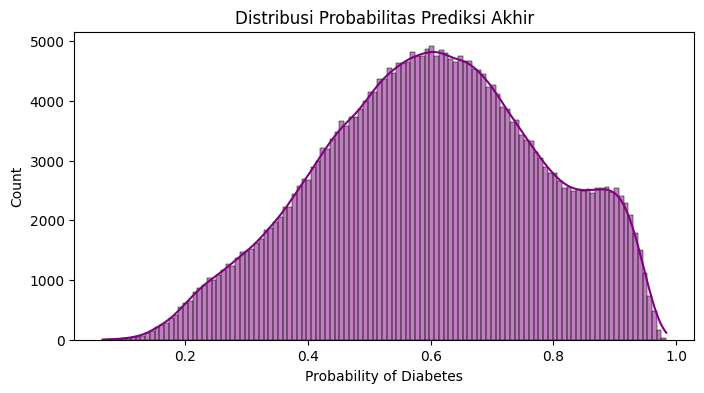

In [8]:
total_score = mean_xgb + mean_hgb + mean_rf
w_xgb = mean_xgb / total_score
w_hgb = mean_hgb / total_score
w_rf  = mean_rf / total_score

print(f"\nAuto Weights: XGB={w_xgb:.3f}, HGB={w_hgb:.3f}, RF={w_rf:.3f}")

# Gabungkan prediksi
final_preds = (w_xgb * preds_xgb) + (w_hgb * preds_hgb) + (w_rf * preds_rf)

submission['diagnosed_diabetes'] = final_preds

if not os.path.exists("../outputs"):
    os.makedirs("../outputs")
submission.to_csv('../outputs/submission.csv', index=False)

print("Submission file saved to outputs/submission.csv")

plt.figure(figsize=(8, 4))
sns.histplot(final_preds, kde=True, color='purple')
plt.title('Distribusi Probabilitas Prediksi Akhir')
plt.xlabel('Probability of Diabetes')
plt.savefig('../outputs/distribusi_prediksi_akhir.png')
plt.show()

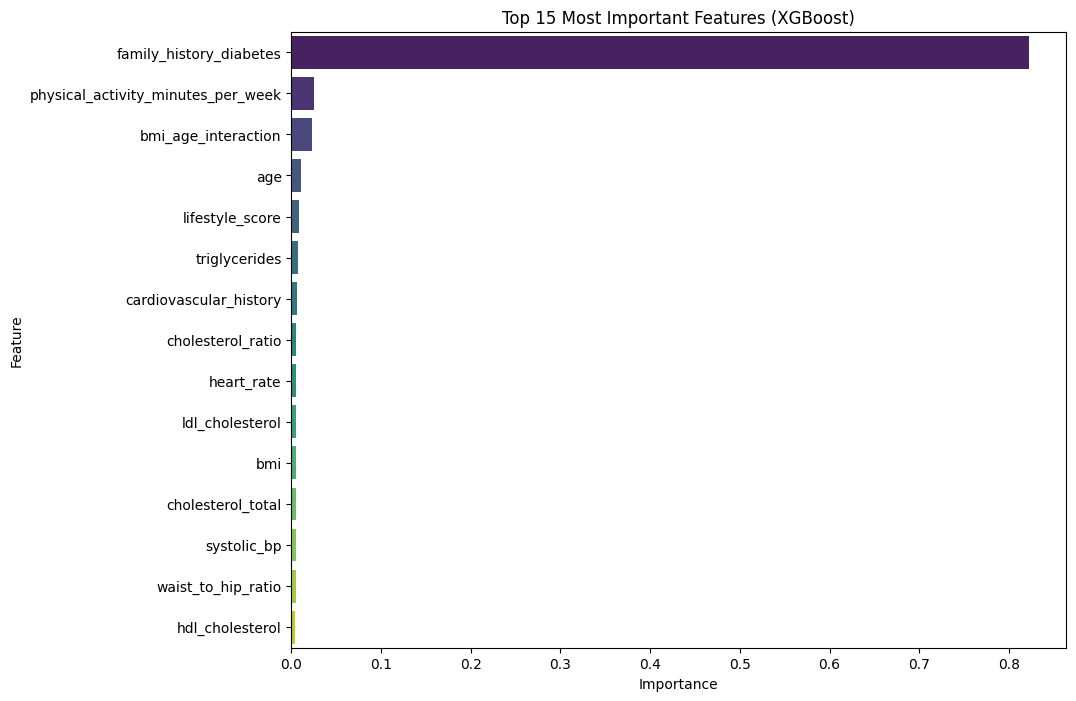

In [9]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance.head(15), palette='viridis')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.savefig('../outputs/feature_importance.png')
plt.show()